In [3]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
labeldata_load, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image_load, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

(512, 512, 265)
(512, 512, 265)


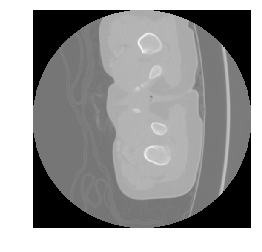

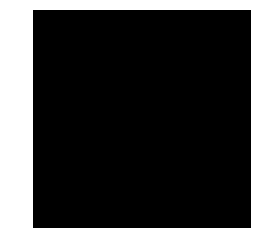

In [6]:
image = image_load
labeldata = labeldata_load
print(image.shape)
print(labeldata.shape)
imshow(image)
imshow(labeldata)

image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)


(1, 512, 512)


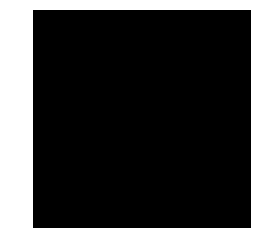

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [11]:

lbl = labeldata[[13],...] #takes one slice of the 265
print(lbl.shape)
imshow(lbl)

print(lbl)
np.where(lbl > 1)

# right now for the labels, the area containing the tumor is represented by 1s; every other pixel is 0
# do we need to make the labels for each slice binary in [0, 1]?  or do we keep the labels for each slice
# as a 2d array containing 0s and 1s?

(265, 512, 512, 1)
(265, 512, 512, 1)


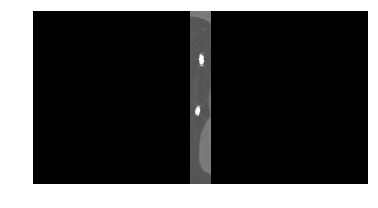

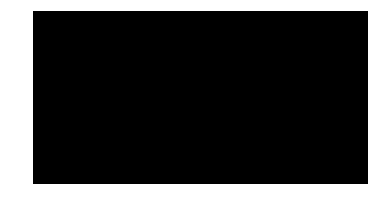

In [20]:

image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)

#add the fourth dimension (modality) which is just 1
image = np.expand_dims(image, axis=3)
labeldata = np.expand_dims(labeldata, axis=3)

print(image.shape)
print(labeldata.shape)
imshow(image)
imshow(labeldata)

(1, 512, 512, 1)
(1, 512, 512, 1)


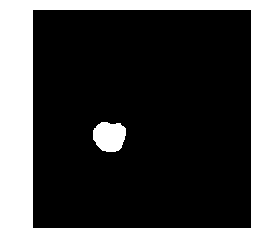

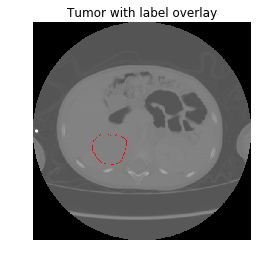

In [21]:
lbl = labeldata[[132],...] #takes one slice of the 265
img = image[[132],...] #takes one slice of the 265

print(img.shape)
print(lbl.shape)

# imshow(img)
imshow(lbl)
imshow(dat=img, lbl=lbl, title='Tumor with label overlay')

In [22]:
import tensorflow as tf


print(type(img))
print(img.shape)


X = tf.placeholder(tf.float32, [None, 512, 512, 1])

conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')
relu = tf.nn.relu(conv)
pool = tf.layers.max_pooling2d(relu, pool_size=(2, 2), strides=(2, 2))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

output = sess.run(pool, feed_dict={X: img})

print(output.shape)

<class 'numpy.ndarray'>
(1, 512, 512, 1)
(1, 256, 256, 8)


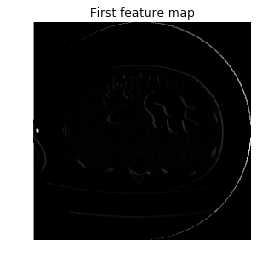

In [23]:
imshow(output[..., 0], title='First feature map')


In [24]:
sess.close()


In [25]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 512, 512, 1], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In [26]:
import net

In [27]:
pred = net.create_classifier2(X, training=mode)
print(pred.shape)
print(pred)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

(?, 2)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 2), dtype=float32)


In [28]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
print(lbl.shape)

(1, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)
REAL (tumor, y/n?): y
PRED (tumor, y/n?): n
LOSS (lower value is better prediction): 3.542008


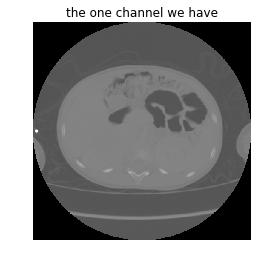

[1]


In [29]:
# dat, lbl = data.load(mode='train', n=1)
print(img.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
sce, logits = sess.run([loss, pred], {X: img, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(img[..., 0], title='the one channel we have')
print(lbl)

In [30]:
sess.close()

In [20]:
# taken from: https://www.tensorflow.org/tutorials/estimators/cnn
print("new section")

new section


In [ ]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)
  print("***********\n\n\n\n***********")
  print("logits")
  print(logits.shape)
  print(logits)
    
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

In [ ]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=201,
    hooks=[logging_hook])

In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)